In [1]:
import pandas as pd, numpy as np
import ast
from treeinterpreter import treeinterpreter as ti
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, ParameterGrid, GridSearchCV, LeaveOneOut, KFold
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, make_scorer
import plotly.express as px
import shap
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance

data = pd.read_csv('./results/features_df.csv')
data

,Corpus,Type,Avg Word Length,Avg Sentence Length,TTR,MATTR,MTLD,Morpheme TTR,Avg Segs Per Word,Avg Forms Per Stem,Char Dist Entr,Word Dist Entr,Text Entr,Lex Entr,Rev Lex Entr
0,eo,con,5.175,18.909,10.708,0.692,67.482,7.535,1.859,3.506,4.164,10.923,4.435,6.303,7.016
1,nl,nat,5.419,18.194,8.559,0.694,74.165,12.467,1.809,3.044,4.117,10.593,4.389,6.407,6.746
2,is,nat,5.375,15.055,11.727,0.747,115.342,9.847,1.931,4.128,4.468,11.512,5.455,5.993,6.376
3,pl,nat,6.248,14.951,14.890,0.825,278.888,6.639,1.894,3.709,4.553,12.905,5.072,5.611,5.898
4,fr,nat,5.160,23.120,7.461,0.721,91.865,7.109,1.771,2.759,4.179,10.711,4.104,6.256,6.779
5,vo,con,5.072,11.266,2.455,0.622,39.447,15.287,1.567,1.938,4.256,7.666,1.281,8.702,9.037
6,af,nat,5.067,20.496,6.987,0.645,59.938,13.894,1.770,2.861,4.072,9.993,4.757,6.639,6.986
7,vi,nat,3.498,29.835,1.749,0.732,94.751,27.439,1.344,1.453,4.855,9.717,4.768,11.878,11.432
8,oc,nat,5.215,18.660,7.185,0.715,87.187,7.674,1.793,2.805,4.173,10.546,3.530,6.741,7.118
9,en,nat,5.087,21.301,6.079,0.697,77.659,10.049,1.661,2.360,4.167,10.673,4.771,7.106,7.601


### Decision Tree

Unnamed: 0                                                         0
params             {'criterion': 'gini', 'max_depth': None, 'max_...
tp                                                                 5
fp                                                                 1
tn                                                                17
fn                                                                 1
incorrect_preds                             {'eo': 'fn', 'nl': 'fp'}
precision                                                   0.833333
recall                                                      0.833333
f1                                                          0.833333
Name: 0, dtype: object
Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


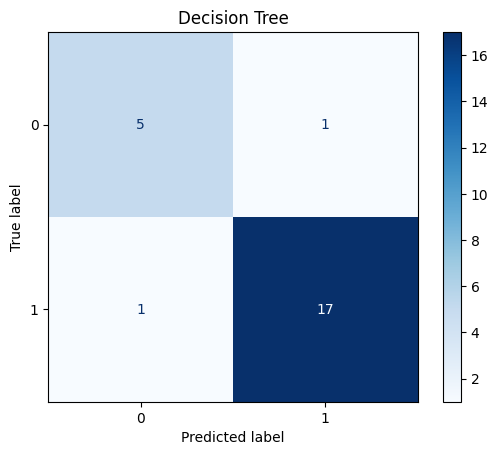

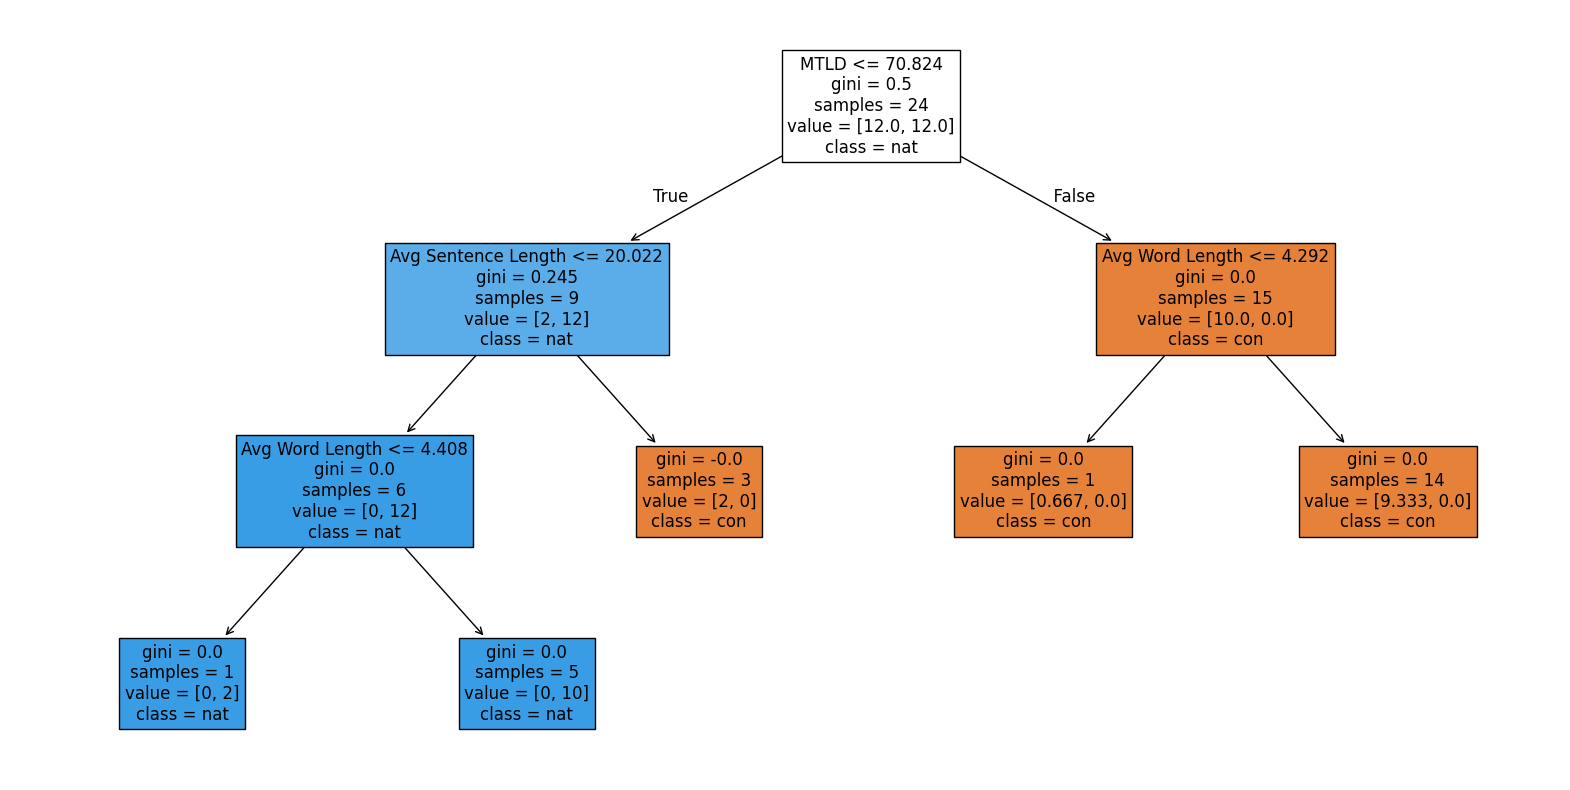

In [2]:
X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':1, 'nat':0}).values

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 4, 6, 8, 10, 20],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [None, 'sqrt', 'log2'],
}
grid = ParameterGrid(param_grid=param_grid)

def loocv(X, y, params):
    tp, fp, tn, fn = 0, 0, 0, 0
    incorrect_preds = {}
    
    for i in range(len(y)):
        X_train = np.concatenate([X[:i], X[i+1:]], axis=0)
        y_train = np.concatenate([y[:i], y[i+1:]], axis=0)
        X_test = X[i].reshape(1, -1)
        y_test = y[i]
        
        clf = DecisionTreeClassifier(
            criterion=params['criterion'],
            splitter=params['splitter'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            max_features=params['max_features'],
            class_weight='balanced',
            random_state=42,
        )
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)[0]
        
        if y_test == 1 and y_pred == 1:
            tp += 1
        elif y_test == 0 and y_pred == 1:
            fp += 1
            incorrect_preds[data['Corpus'][i]] = 'fp'
        elif y_test == 0 and y_pred == 0:
            tn += 1
        elif y_test == 1 and y_pred == 0:
            fn += 1
            incorrect_preds[data['Corpus'][i]] = 'fn'
    
    return tp, fp, tn, fn, incorrect_preds


results = []
# for params in grid:
#     tp, fp, tn, fn, incorrect_preds = loocv(X, y, params)
    
#     precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#     recall = tp / (tp + fn) if (tp + fn) > 0 else 0
#     f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
#     results.append({
#         'params': params,
#         'tp': tp,
#         'fp': fp,
#         'tn': tn,
#         'fn': fn,
#         'incorrect_preds': incorrect_preds,
#         'precision': precision,
#         'recall': recall,
#         'f1': f1,
#     })
    
# tree_finetuning_df = pd.DataFrame(results)
# tree_finetuning_df.to_csv('./results/tree_finetuning_df.csv')
tree_finetuning_df = pd.read_csv('./results/tree_finetuning_df.csv')
best_tree = tree_finetuning_df.sort_values(by='f1', ascending=False).iloc[0]
print(best_tree)
best_params = ast.literal_eval(best_tree['params'])
print(f"Best parameters: {best_params}")

cm = np.array([[best_tree['tp'], best_tree['fn']], [best_tree['fp'], best_tree['tn']]])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Decision Tree")
plt.savefig('./results/CM_decision_tree.png', bbox_inches='tight')
plt.show()

tree = DecisionTreeClassifier(
    criterion=best_params['criterion'],
    splitter=best_params['splitter'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    class_weight='balanced',
    random_state=42,
)

tree.fit(X, y)
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=data.columns[2:].values, class_names=data['Type'], fontsize=12)
plt.savefig('./results/decisiontree.png', bbox_inches='tight')
plt.show()

#### Decision Tree SHAP

  0%|          | 0/24 [00:00<?, ?it/s]

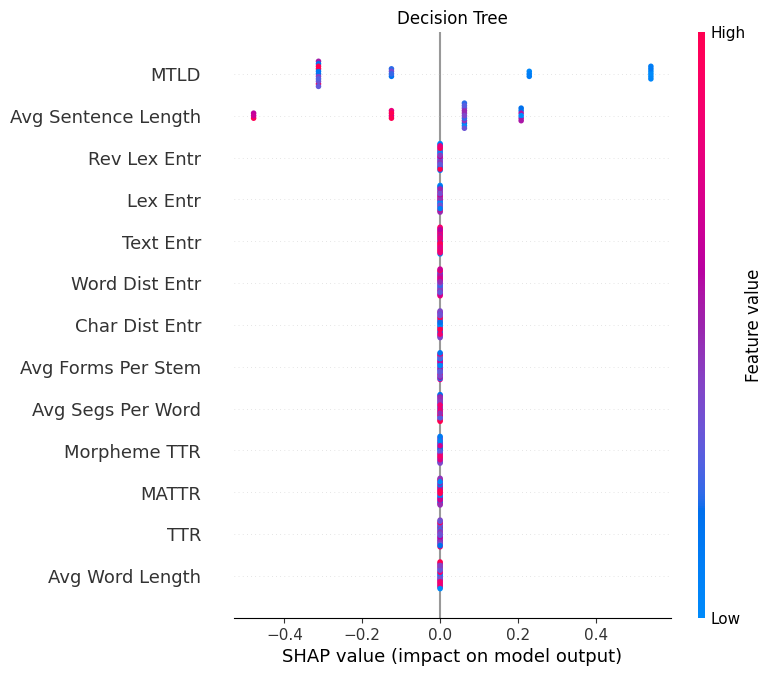

In [3]:
shap.initjs()
explainer = shap.KernelExplainer(tree.predict, X)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values=shap_values, features=X, show=False, feature_names=data.iloc[:,2:].columns)
plt.tight_layout()
plt.title('Decision Tree')
plt.savefig("./results/DT_SHAP_values.png", bbox_inches='tight')
plt.show()

### Random Forest

In [16]:
# # Get incorrect predictions from fine-tuned model

# X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':1, 'nat':0}).values

# param_grid = {
#     'n_estimators': [50],
#     'max_features': ['sqrt'],
#     'max_depth': [None],
#     'min_samples_split': [7],
#     'min_samples_leaf': [3],
#     'criterion': ['entropy'],
#     'bootstrap': [True]
# }
# grid = ParameterGrid(param_grid=param_grid)

# def loocv(X, y, params):
#     tp, fp, tn, fn = 0, 0, 0, 0
#     incorrect_preds = {}
    
#     for i in range(len(y)):
#         X_train = np.concatenate([X[:i], X[i+1:]], axis=0)
#         y_train = np.concatenate([y[:i], y[i+1:]], axis=0)
#         X_test = X[i].reshape(1, -1)
#         y_test = y[i]
        
#         clf = RandomForestClassifier(
#             n_estimators=params['n_estimators'],
#             max_features=params['max_features'],
#             max_depth=params['max_depth'],
#             min_samples_split=params['min_samples_split'],
#             min_samples_leaf=params['min_samples_leaf'],
#             criterion=params['criterion'],
#             bootstrap=params['bootstrap'],
#             class_weight='balanced',
#             random_state=42,
#         )
        
#         clf.fit(X_train, y_train)
#         y_pred = clf.predict(X_test)[0]
        
#         if y_test == 1 and y_pred == 1:
#             tp += 1
#         elif y_test == 0 and y_pred == 1:
#             fp += 1
#             incorrect_preds[data['Corpus'][i]] = 'fp'
#         elif y_test == 0 and y_pred == 0:
#             tn += 1
#         elif y_test == 1 and y_pred == 0:
#             fn += 1
#             incorrect_preds[data['Corpus'][i]] = 'fn'
    
#     return tp, fp, tn, fn, incorrect_preds


# results = []
# for params in grid:
#     tp, fp, tn, fn, incorrect_preds = loocv(X, y, params)
    
#     precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#     recall = tp / (tp + fn) if (tp + fn) > 0 else 0
#     f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
#     results.append({
#         'params': params,
#         'tp': tp,
#         'fp': fp,
#         'tn': tn,
#         'fn': fn,
#         'incorrect_preds': incorrect_preds,
#         'precision': precision,
#         'recall': recall,
#         'f1': f1,
#     })
    
# rf_incorrect_df = pd.DataFrame(results)
# # rf_finetuning_df.to_csv('./results/rf_finetuning_df.csv')
# # rf_finetuning_df = pd.read_csv('./results/rf_finetuning_df.csv')
# best_rf = rf_incorrect_df.sort_values(by='f1', ascending=False).iloc[0]
# # best_params = ast.literal_eval(best_rf['params'])
# best_params = best_rf['params']
# print(best_rf)
# print(f"Best parameters: {best_params}")

params             {'bootstrap': True, 'criterion': 'entropy', 'm...
tp                                                                 5
fp                                                                 1
tn                                                                17
fn                                                                 1
incorrect_preds                             {'eo': 'fn', 'tl': 'fp'}
precision                                                   0.833333
recall                                                      0.833333
f1                                                          0.833333
Name: 0, dtype: object
Best parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 50}


Unnamed: 0                                                 3604
params        {'bootstrap': True, 'criterion': 'entropy', 'm...
tp                                                            5
fp                                                            1
tn                                                           17
fn                                                            1
precision                                              0.833333
recall                                                 0.833333
f1                                                     0.833333
Name: 3604, dtype: object
Best parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 50}


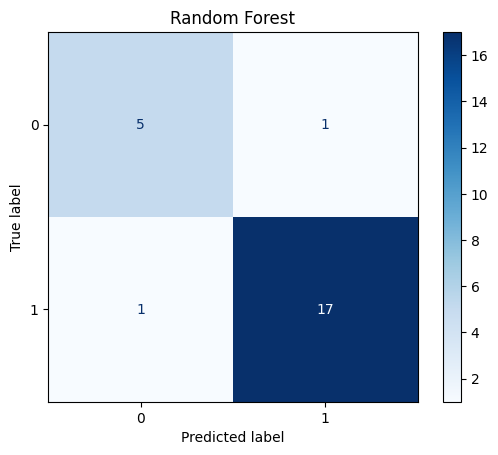

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_leaf=3, min_samples_split=7, n_estimators=50,
                       random_state=42)

In [4]:
X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':1, 'nat':0}).values

param_grid = {
    'n_estimators': [5, 10, 15, 20, 50, 100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 2, 4, 6, 8, 10, 20],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'bootstrap': [True]
}
grid = ParameterGrid(param_grid=param_grid)

def loocv(X, y, params):
    tp, fp, tn, fn = 0, 0, 0, 0
    
    for i in range(len(y)):
        X_train = np.concatenate([X[:i], X[i+1:]], axis=0)
        y_train = np.concatenate([y[:i], y[i+1:]], axis=0)
        X_test = X[i].reshape(1, -1)
        y_test = y[i]
        
        clf = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_features=params['max_features'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            criterion=params['criterion'],
            bootstrap=params['bootstrap'],
            class_weight='balanced',
            random_state=42,
        )
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)[0]
        
        if y_test == 1 and y_pred == 1:
            tp += 1
        elif y_test == 0 and y_pred == 1:
            fp += 1
        elif y_test == 0 and y_pred == 0:
            tn += 1
        elif y_test == 1 and y_pred == 0:
            fn += 1
    
    return tp, fp, tn, fn


results = []
# for params in grid:
#     tp, fp, tn, fn = loocv(X, y, params)
    
#     precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#     recall = tp / (tp + fn) if (tp + fn) > 0 else 0
#     f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
#     results.append({
#         'params': params,
#         'tp': tp,
#         'fp': fp,
#         'tn': tn,
#         'fn': fn,
#         'precision': precision,
#         'recall': recall,
#         'f1': f1,
#     })
    
# rf_finetuning_df = pd.DataFrame(results)
# rf_finetuning_df.to_csv('./results/rf_finetuning_df.csv')
rf_finetuning_df = pd.read_csv('./results/rf_finetuning_df.csv')
best_rf = rf_finetuning_df.sort_values(by='f1', ascending=False).iloc[0]
best_params = ast.literal_eval(best_rf['params'])
print(best_rf)
print(f"Best parameters: {best_params}")

cm = np.array([[best_rf['tp'], best_rf['fn']], [best_rf['fp'], best_rf['tn']]])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Random Forest")
plt.savefig('./results/CM_random_forest.png', bbox_inches='tight')
plt.show()

rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    bootstrap=best_params['bootstrap'],
    class_weight='balanced',
    random_state=42,
)

rf.fit(X, y)

#### Random Forest SHAP

  0%|          | 0/24 [00:00<?, ?it/s]

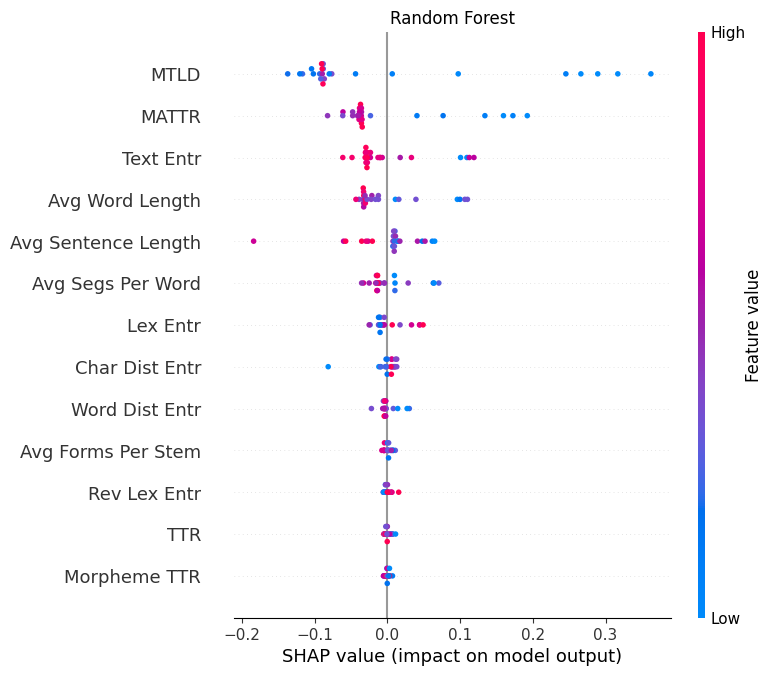

In [5]:
# SHAP feature importances
shap.initjs()
explainer = shap.KernelExplainer(rf.predict, X)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names=data.iloc[:,2:].columns.values, show=False)
# plt.tight_layout()
plt.title('Random Forest')
plt.savefig("./results/RF_SHAP_values.png", bbox_inches='tight')
plt.show()

In [ ]:
# Tree Interpreter

prediction, bias, contributions = ti.predict(best_rf, X)